## **3D elastic VTI wave equation implementation on a staggered grid**

This is a first attempt at implementing the elastic wave equations in 3D vertical transversely isotropic (VTI) media as described in [1].

This notebook will attempt to implement this FD scheme and recreate the results from both Numerical examples [4.1] and [4.2].

<br> Chirayu Khimji 
<br> Independent Research Project 
<br> MSc Applied Computational Science and Engineering - Imperial College London 
<br> IRP Supervisors: Dr. Gerard Gorman + Dr. Rhodri Nelson


## Introduction

To be added in proper academic syntax


## Outline
this cell needs to be completed in more detail when tasks below are completed

1. Implement 3D elastic VTI wave propagation (Vectorized Approach) using temporal high-accuracy staggered-grid finite-difference scheme

2. Implement 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme i.e. like the paper [1].

3. Testing: Compare the resultants of these two implemenations to make sure everything works

## 3D Elastic VTI wave-equations
The paper expresses the elastic wave equations in 3D VTI media in the conventional velocity-stress format as a set of scalar PDEs: 

$$
\begin{aligned}
\frac{\partial v_x}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xx}}{\partial x} + \frac{\partial \tau_{xy}}{\partial y} + \frac{\partial \tau_{xz}}{\partial z} \right) \\

\frac{\partial v_y}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xy}}{\partial x} + \frac{\partial \tau_{yy}}{\partial y} + \frac{\partial \tau_{yz}}{\partial z} \right) \\

\frac{\partial v_z}{\partial t} &= \frac{1}{\rho} \left( \frac{\partial \tau_{xz}}{\partial x} + \frac{\partial \tau_{yz}}{\partial y} + \frac{\partial \tau_{zz}}{\partial z} \right) \\

\frac{\partial \tau_{xx}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} - 2c_{66}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\

\frac{\partial \tau_{yy}}{\partial t} &= c_{11}\frac{\partial v_{x}}{\partial x} - 2c_{66}\frac{\partial v_{x}}{\partial x} + c_{11}\frac{\partial v_{y}}{\partial y} + c_{13}\frac{\partial v_{z}}{\partial z} \\

\frac{\partial \tau_{zz}}{\partial t} &= c_{13}\frac{\partial v_{x}}{\partial x} + c_{13}\frac{\partial v_{y}}{\partial y} + c_{33}\frac{\partial v_{z}}{\partial z} \\

\frac{\partial \tau_{zz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial x} + c_{44}\frac{\partial v_{x}}{\partial z} \\

\frac{\partial \tau_{yz}}{\partial t} &= c_{44}\frac{\partial v_{z}}{\partial y} + c_{44}\frac{\partial v_{y}}{\partial z} \\

\frac{\partial \tau_{xy}}{\partial t} &= c_{66}\frac{\partial v_{y}}{\partial x} + c_{66}\frac{\partial v_{x}}{\partial y} \\
\end{aligned}
$$

Stiffness coefficients in elastic VTI media can be given by (Thomsen 1986):

$
\begin{aligned}
c_{11} &= \rho \left(1 + 2\epsilon\right)v_{p0}^{2} \\
c_{33} &= \rho v_{p0}^{2} \\
c_{44} &= \rho v_{s0}^{2} \\
c_{66} &= \rho \left(1 + 2\gamma\right)v_{s0}^{2} \\
c_{13} &= \rho v_{p0}^{2}\sqrt{f\left(f + 2\delta\right)} - \rho v_{s0}^{2} \\
f &= 1 - v_{s0}^{2}/v_{p0}^{2} \\
\end{aligned}
$




## Converted into Vectorial form

Elastic Coefficient Matrix of the VTI Media medium:

$C = \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} & 0 & 0 & 0 \\ c_{11} - 2c_{66} & c_{11} & c_{13} & 0 & 0 & 0 \\ c_{13} & c_{13} & c_{33} & 0 & 0 & 0 \\ 0 & 0 & 0 & c_{44} & 0 & 0 \\ 0 & 0 & 0 & 0 & c_{44} & 0 \\ 0 & 0 & 0 & 0 & 0 & c_{66} \end{bmatrix} \\ $

The elastic coefficient matrix of a VTI Media is taken into the vectorial form of the elastic wave equation in order to derive the Scalar PDEs given by the paper [1]. In order to easily implement $C$ into the Elastic Wave equations' vectorial form, we can disregard its null values and spilt $C$ into two distinct $(3$x$3)$ matrices $C_1$ and $C_2$:

$
\begin{aligned}
C_{1} &= \begin{bmatrix}c_{11} & c_{11} - 2c_{66} & c_{13} \\ c_{11} - 2c_{66} & c_{11} & c_{13} \\ c_{13} & c_{13} & c_{33} \end{bmatrix} \\ 
\\
C_{2} &= \begin{bmatrix}c_{44} & 0 & 0 \\ 0 & c_{44} & 0 \\ 0 & 0 & c_{66} \end{bmatrix}  \\
\\
\end{aligned}
$

Using $C_1$ and $C_2$, a higher-level representation of the scalar PDEs above can be derived from Hooke's law and the equation of motion:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = C_1 tr(\nabla v) \mathbf{I}  + C_2(\nabla v + (\nabla v)^T)
\end{cases}

since $tr(\nabla v)$ is the divergence of $v$ we can rewrite it as:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau \\
&\frac{d \tau}{dt} = C_1 \text{diag}(\nabla . v) + C_2 (\nabla v + (\nabla v)^T)
\end{cases}

where $v$ is a vector valued function:

$v(t, x, y, z) = \left( v_x(t, x, y, z), v_y(t, x, y, z), v_z(t, x, y, z) \right)$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y, z) = \begin{bmatrix}\tau_{xx}(t, x, y, z) & \tau_{xy}(t, x, y, z) & \tau_{xz}(t, x, y, z) \\\tau_{xy}(t, x, y, z) & \tau_{yy}(t, x, y, z) & \tau_{xy}(t, x, y, z) \\ \tau_{xz}(t, x, y, z) & \tau_{xy}(t, x, y, z) & \tau_{zz}(t, x, y, z) \end{bmatrix}$


This representation provides a higher-level of abstraction and makes the implementation of this SG-FD scheme relatively simple by using Devito's high-level tensorial types.



## Imports
all required imports used in this notebook are below for consistency.

In [12]:
# Required imports:
import numpy as np
import sympy as sp

from devito import *
from examples.seismic import RickerSource, TimeAxis, Receiver
from examples.seismic import plot_image, plot_velocity, plot_perturbation
from examples.seismic import ModelElasticVTI
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from timeit import default_timer as timer

# These lines force images to be displayed in the notebook, and scale up fonts 
%matplotlib inline
mpl.rc('font', size=14)

# define 32 bit floating point as the precision type 
dtype = np.float32

# Set the default language to openmp
#configuration['language'] = 'openmp'

# Set logging to debug, captures statistics on the performance of operators
configuration['log-level'] = 'DEBUG'


## Instantiate the Devito grid for a three dimensional problem
define the grid the same as the 3D homogenous model described in 4.1. This still needs to be fixed below is a sample structure

In [13]:
# Define dimensions for the interior of the model
nx, ny, nz = 301, 301, 301
dx,dy,dz = 12.0, 12.0, 12.0          # Grid spacing in m
shape = (nx, ny, nz)                 # Number of grid points
spacing = (dx, dy, dz)               # Domain size is now 5 km by 5 km
origin = (0., 0., 0.)                # Origin of coordinate system, specified in m.
extent = tuple([s*(n-1) for s, n in zip(spacing, shape)])

# Define dimensions for the model padded with absorbing boundaries
npad = 0         # number of points in absorbing boundary region (all sides)
nxpad, nypad, nzpad = nx+2*npad, ny+2*npad, nz+2*npad
shape_pad   = np.array(shape) + 2 * npad
origin_pad  = tuple([o - s*npad for o, s in zip(origin, spacing)])
extent_pad  = tuple([s*(n-1) for s, n in zip(spacing, shape_pad)])

#Thomsen's anisotropy parameters
epsilon = 0.25
delta = -0.10
gamma = -0.05

#initial conditions
nbl = 0
vp = 3.5 #km/s
vs = 2.4 #km/s
rho= 2.6 #kg/m**3

so = 4 #spatial order
to = 2 #temporal order

model = ModelElasticVTI(origin=origin, spacing = spacing, shape=shape, space_order=so, 
vp=vp, vs=vs, rho=rho, epsilon=epsilon, delta=delta, gamma=gamma, nbl=nbl)

print("shape;           ", shape)
print("origin;          ", origin)
print("spacing;         ", spacing)
print("extent;          ", extent)
print("")
print("shape_pad;       ", shape_pad)
print("origin_pad;      ", origin_pad)
print("extent_pad;      ", extent_pad)

print("")
print("grid.shape;      ", model.grid.shape)
print("grid.origin;     ", model.grid.origin)
print("grid.extent;     ", model.grid.extent)
print("grid.spacing_map;", model.grid.spacing_map)




shape;            (301, 301, 301)
origin;           (0.0, 0.0, 0.0)
spacing;          (12.0, 12.0, 12.0)
extent;           (3600.0, 3600.0, 3600.0)

shape_pad;        [301 301 301]
origin_pad;       (0.0, 0.0, 0.0)
extent_pad;       (3600.0, 3600.0, 3600.0)

grid.shape;       (301, 301, 301)
grid.origin;      (o_x, o_y, o_z)
grid.extent;      (3600.0, 3600.0, 3600.0)
grid.spacing_map; {h_x: 12.0, h_y: 12.0, h_z: 12.0}


In [14]:
# Now we create the velocity and pressure fields
# PDE fn's:
x, y, z = model.grid.dimensions
damp = model.damp

#Velocity
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)

#Stress
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)

# Symbolic representation of the model grid spacing
s = model.grid.stepping_dim.spacing 


##to review
#Create the staggered grid updates
#t = model.grid.stepping_dim
#time = model.grid.time_dim

## Define the simulation time range


In [15]:
t0 = dtype(0.)     # Simulation time start
tn = dtype(1000.)  # Simulation time end (1 second = 1000 msec)
#dt = np.float32(0.2 * np.min(spacing) / np.max(v.data)) #CFL condition
#dt = 1.2

dt = model.critical_dt #CFL condition
time_range = TimeAxis(start=t0, stop=tn, step=dt)
print("Time min,max,dt,num; %10.6f %10.6f %10.6f %d" % (t0, tn, dt, int(tn//dt) + 1))

Time min,max,dt,num;   0.000000 1000.000000   1.683000 595


## Define the acquisition geometry: locations of explosive source and recievers

For Numercial Example [4.1] in [1]:
A 38 Hz center frequency Ricker wavelet source, located at (x, y, z) = (1800m, 1800m, 1800m) and is added into $v_x$ component to generate vibration.

For Ricker wavelet, the source signature $g(t)$ is the derivative of a Gaussian pulse:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

Allocating memory for src(596, 1)
Allocating memory for src_coords(1, 3)
Allocating memory for rec_coords(301, 3)
src_coords [x,y,z]: [[1800. 1800. 1800.]]


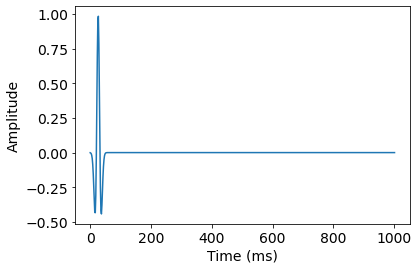

In [16]:
# Centered Source with 38 Hz center frequency
fpeak = 0.038
src = RickerSource(name='src', grid=model.grid, f0=fpeak, npoint=1, time_range=time_range)
src.coordinates.data[:] = np.array([1800., 1800., 1800.])

# line of receivers along right edge of model
## this needs to be fixed later on to be in line with the paper
rec = Receiver(name='rec', grid=model.grid, npoint=nz, time_range=time_range)
rec.coordinates.data[:] = np.array([3600., 3600., 1800.])

print("src_coords [x,y,z]:", src.coordinates.data)
#print("rec_coords [x,y,z]:", rec.coordinates.data)

#plot time signature to view wavelet
src.show()


In [6]:


#source injection term
src_xx = src.inject(field=tau[0, 0].forward, expr=src)
src_yy = src.inject(field=tau[1, 1].forward, expr=src)
src_zz = src.inject(field=tau[2, 2].forward, expr=src)
src_term = src_xx + src_yy + src_zz

# Create interpolation expression for receivers
rec_term_no = rec.interpolate(expr=tau.forward)

ro = model.rho

#### For VTI Media
#Thomsen's anisotropy parameters
eps = model.epsilon
delta = model.delta
gamma = model.gamma

#delta = -0.10

# Thomsen's stiffness coefficients in elastic VTI media from The stiffness matrix, otherwise known as the elastic modulus matrix
c11 = ro*(1+2*eps)*vp**2
c33 = ro*vp**2
c44 = ro*vs**2
c66 = ro*(1+2*gamma)*vs**2
f = 1 - vs**2/vp**2

c13 = ro*vp**2*np.sqrt(f*(f+2*delta))-ro*vs**2


#Assemble full C matrix for VTI media
C = np.diagflat([c11,c11,c33,c44,c44,c66])
C[0][1] = c11 - 2*c66
C[1][0] = C[0][1]
C[0][2] = c13
C[2][0] = C[0][2]
C[2][1] = C[0][2]
C[1][2] = C[2][1]
#print(C)



TypeError: loop of ufunc does not support argument 0 of type Add which has no callable sqrt method

In [25]:

#Split full C matrix for VTI media
C1= np.diagflat([c11,c11,c33])
C1[0][1] = c11 - 2*c66
C1[1][0] = C1[0][1]
C1[0][2] = c13
C1[2][0] = C1[0][2]
C1[2][1] = C1[0][2]
C1[1][2] = C1[2][1]
print(C1)

C2= np.diagflat([c44,c44,c66])
print(C2)

[[12.25*rho*(2*epsilon + 1)
  12.25*rho*(2*epsilon + 1) - 11.52*rho*(2*gamma + 1)
  -0.639492212680464*rho]
 [12.25*rho*(2*epsilon + 1) - 11.52*rho*(2*gamma + 1)
  12.25*rho*(2*epsilon + 1) -0.639492212680464*rho]
 [-0.639492212680464*rho -0.639492212680464*rho 12.25*rho]]
[[5.76*rho 0 0]
 [0 5.76*rho 0]
 [0 0 5.76*rho*(2*gamma + 1)]]


In [19]:
irho = 1/ro 
# Particle Velocity working for VTI Media
u_v = Eq(v.forward, v + s*irho*div(tau))

##### Need to work out the following by hand:


# Stress Equation stencil for the elastic case needs to be fixed for Elastic VTI

#Assembles the PDE symbolically
#u_t = Eq(tau.forward, tau + s * C1*diag(div(v.forward)) + s * C2*(grad(v.forward) + grad(v.forward).T)) ##need to fix this line 
#stencil = [u_v] + [u_t]


In [20]:
#u_v check
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y, z), v_y(t + dt, x, y + h_y/2, z), v_z(t + dt, x, y, z + h_z/2)), Vector(dt*(Derivative(t_xx(t, x, y, z), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), y) + Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), z))/rho + v_x(t, x + h_x/2, y, z), dt*(Derivative(t_xy(t, x + h_x/2, y + h_y/2, z), x) + Derivative(t_yy(t, x, y, z), y) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), z))/rho + v_y(t, x, y + h_y/2, z), dt*(Derivative(t_xz(t, x + h_x/2, y, z + h_z/2), x) + Derivative(t_yz(t, x, y + h_y/2, z + h_z/2), y) + Derivative(t_zz(t, x, y, z), z))/rho + v_z(t, x, y, z + h_z/2)))

In [ ]:
#u_t check
u_t

In [37]:
# Testing
X=diag(div(v.forward))
np.matmul(C1,X)
type(C1)

numpy.ndarray

In [24]:
#Forward Simulation
op_fwd = Operator([u_v] + [u_t]  + src_term)
op_fwd()

NameError: name 'u_t' is not defined

Allocating memory for v_x(3, 309, 309, 309)


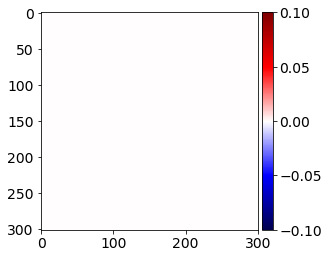

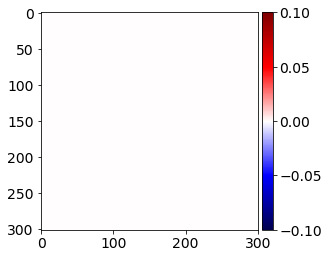

Allocating memory for t_zz(3, 309, 309, 309)


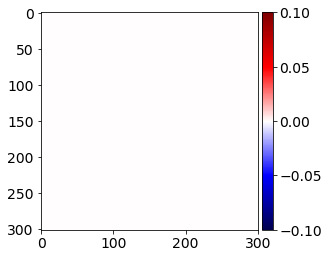

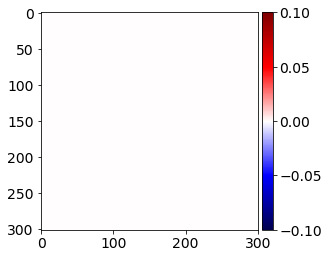

In [23]:
#NBVAL_SKIP

# Mid-points:
mid_x = int(0.5*(v[0].data.shape[1]-1))+1
mid_y = int(0.5*(v[0].data.shape[2]-1))+1

# Plot some selected results:

plot_image(v[0].data[1, :, mid_y, :], cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], cmap="seismic")

plot_image(tau[2, 2].data[1, :, mid_y, :], cmap="seismic")
plot_image(tau[2, 2].data[1, mid_x, :, :], cmap="seismic")

# References

[1] Xu, S. and Liu, Y., 2019. Modeling 3D elastic VTI wave propagation using an optimal k-space operator-based temporal high-accuracy staggered-grid finite-difference scheme. Journal of Applied Geophysics, 170, p.103847.
